In [12]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import utils.mem_utils as mem_utils
import utils.get_data as get_data

In [6]:
def sigmoid(a_in, beta=1):
  """Hyperbolic tangent non-linearity"""
  a_out = tf.subtract(tf.multiply(2.0, tf.divide(1.0,
    tf.add(1.0, tf.exp(tf.multiply(-beta, a_in))))), 1.0)
  return a_out

In [7]:
def memristorize(u_in, memrister_std_eps, memristor_type=None):
  if memristor_type is None:
    return u_in
  elif memristor_type == "gauss":
    get_channel_data = get_data.get_gauss_data
  elif memristor_type == "rram":
    get_channel_data = get_data.get_rram_data
  elif memristor_type == "pcm":
    get_channel_data = get_data.get_pcm_data
  else:
    assert False, ("memristor_type must be None, 'rram', 'gauss', or 'pcm'")
  memristor_data_loc = os.path.expanduser("~")+"/CAE_Project/CAEs/data/Partial_Reset_PCM.pkl" 
  n_mem = 448
  mem_v_min = -1.0
  mem_v_max = 1.0
  u_in_shape = tf.shape(u_in)
  (vs_data, mus_data, sigs_data,
    orig_VMIN, orig_VMAX, orig_RMIN,
    orig_RMAX) = get_channel_data(memristor_data_loc, n_mem, num_ext=5, norm_min=mem_v_min, norm_max=mem_v_max)
  v_clip = tf.clip_by_value(u_in, clip_value_min=mem_v_min, clip_value_max=mem_v_max)
  r = mem_utils.memristor_output(v_clip, memristor_std_eps, vs_data, mus_data, sigs_data,
    interp_width=np.array(vs_data[1, 0] - vs_data[0, 0]).astype('float32'))
  u_out = tf.reshape(r, shape=u_in_shape, name="mem_r")
  return u_out

In [24]:
n_mem = 448
memristor_std_eps = np.random.standard_normal((1, n_mem)).astype(np.float32)
input_voltages = np.load("/home/dpaiton/image_rram_encoding.npz")["data"][None,...]
  
x = tf.placeholder(tf.float32, shape=[1,8,8,7], name="encoded_img")
x_sig = sigmoid(x, beta=1.0)

u = memristorize(x, memristor_std_eps, memristor_type="rram")
u_sig = memristorize(x_sig, memristor_std_eps, memristor_type="rram")

with tf.Session() as sess:
  u_eval, u_sig_eval, input_sig = sess.run([u, u_sig, x_sig], feed_dict={x:input_voltages})

save_path = "/home/dpaiton/"
np.savez(save_path+"u.npz", data=u_eval)
np.savez(save_path+"u_sig.npz", data=u_sig_eval)

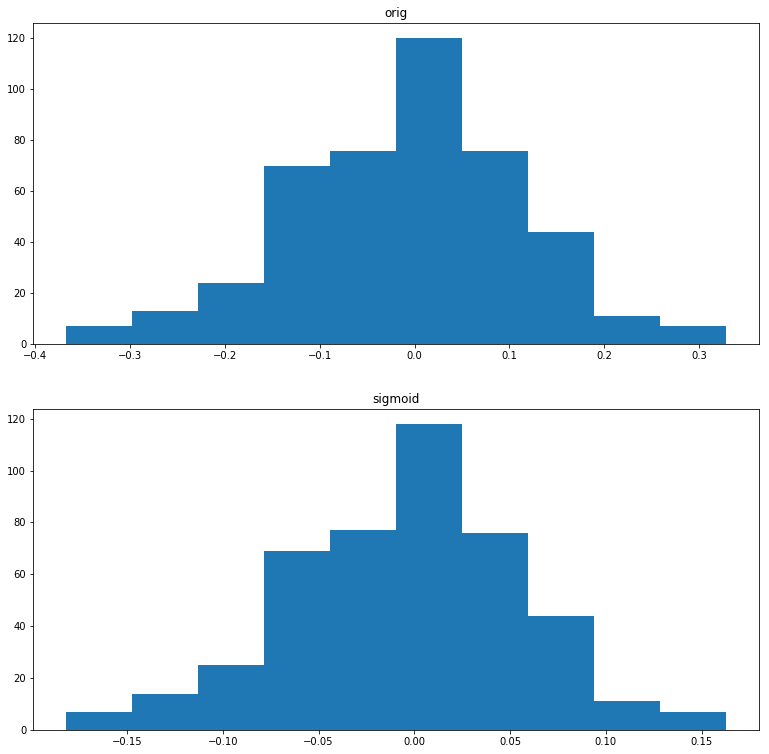

In [25]:
fig, ax = plt.subplots(2, figsize=(13,13))
ax[0].hist(input_voltages.flatten())
ax[0].set_title("orig")
ax[1].hist(input_sig.flatten())
ax[1].set_title("sigmoid")
plt.show()

In [44]:
vals_norm.keys()

['arr_1', 'arr_0', 'arr_2']

In [105]:
vals_norm = np.load("Resistance_Program_Log_Norm.npz")
vals = np.load("Resistance_Program_Log.npz")
#res = vals_norm["arr_1"]
res = vals["arr_1"]

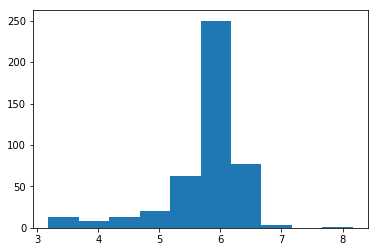

In [106]:
plt.hist(res.flatten())
plt.show()

In [83]:
num_bins = 50
bins = np.linspace(-2,2, num_bins)

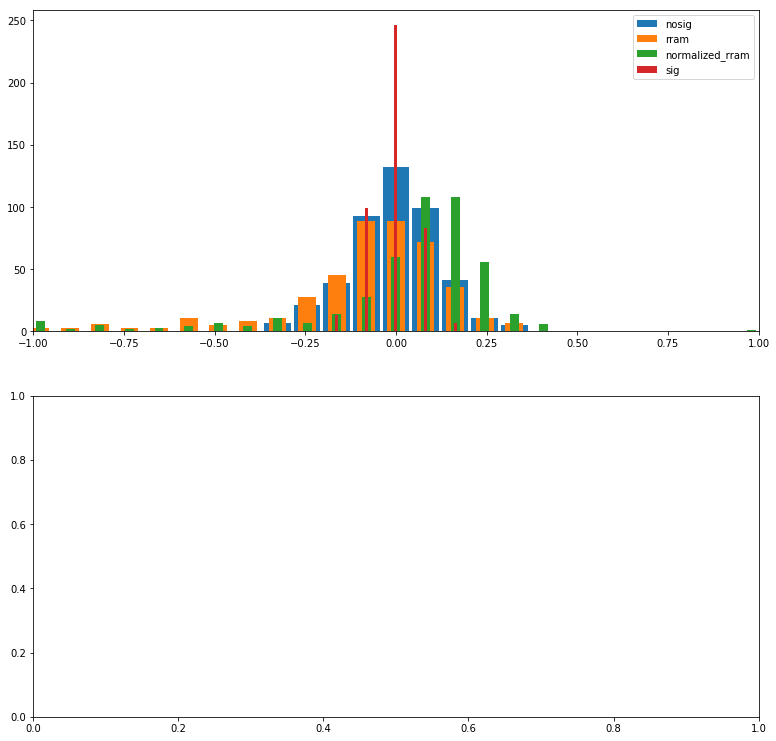

In [103]:
fig, ax = plt.subplots(2, figsize=(13,13))
ax[0].hist(u_eval.flatten(), bins, rwidth=0.9, align='mid', label='nosig')
ax[0].hist(res.flatten(), bins, rwidth=0.6, align='mid', label='rram')
ax[0].hist(normalizer(res,-1.00,1.00).flatten(), bins, rwidth=0.3, align='mid', label='normalized_rram')
ax[0].hist(u_sig_eval.flatten(), bins, rwidth=0.1, align='mid', label='sig')
ax[0].set_xlim([-1,1])
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels)
plt.show()

In [94]:
def normalizer(x,new_min,new_max): 
  x_max = np.amax(x)
  x_min = np.amin(x)
  return (((x-x_min)/(x_max-x_min))*(new_max-new_min)+new_min)

In [51]:
new_res = normalizer(res,-0.35,0.35)

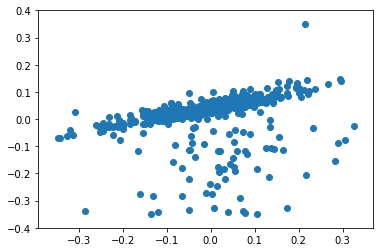

In [63]:
#plt.scatter(u_eval.flatten(), np.random.permutation(new_res.flatten()))
plt.scatter(u_eval.flatten(), new_res.flatten())
plt.show()